# 課題整理

## 3パターンのクーポン発行
1. セールのチラシのみ
1. セールのチラシと1,000円のクーポン
1. セールのチラシと2,000円のクーポン

## 数理モデルによる決定事項
各会員に対してどのパターンのダイレクトメールを送付するかを決定

## 目的関数
- クーポン付与による来客増加数を最大化する

## 制約条件
- 各会員に対して送付するダイレクトメールはいずれか1パターン
- 会員の「予算消費期待値」の合計は100万円以下
- 各パターンのダイレクトメールそれぞれのセグメントに属する会員の10%以上に送付
   - 年齢区分：[19歳以下、20-34歳、35-49歳、50歳以上]
   - 昨年度利用回数：[0, 1, 2, 3回以上]

In [68]:
import pandas as pd
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df_customers = pd.read_csv('customers.csv')
df_customers

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [70]:
df_visit = pd.read_csv('visit_probability.csv')
df_visit

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


<AxesSubplot:>

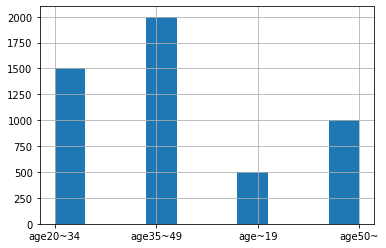

In [71]:
df_customers.age_cat.hist()

<AxesSubplot:>

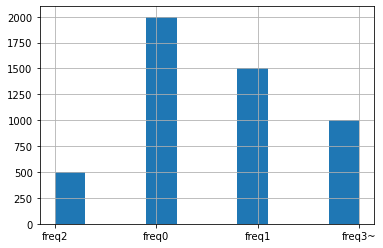

In [72]:
df_customers.freq_cat.hist()

In [73]:
df_customer_pivot = pd.pivot_table(data=df_customers, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
df_customer_pivot = df_customer_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
df_customer_pivot.index = df_customer_pivot.index.map(lambda x: x.replace('age', ''))

<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

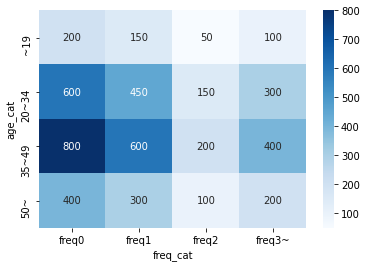

In [74]:
sns.heatmap(df_customer_pivot, annot=True, fmt='d', cmap='Blues')

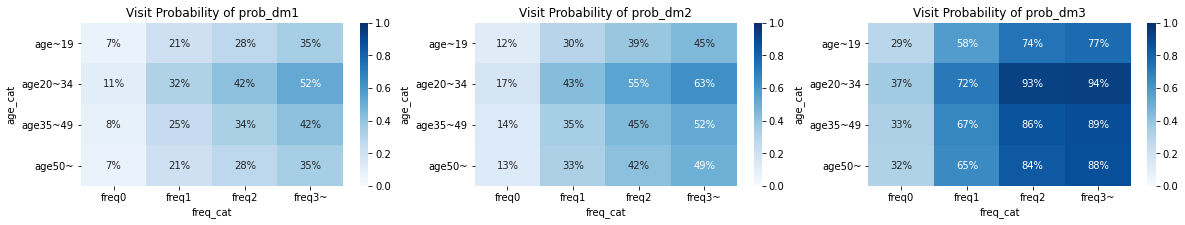

In [75]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20,3))
for i in range(3):
    ptn = f'prob_dm{i+1}'
    df_prob_pivot = pd.pivot_table(data = df_visit, values=ptn, columns='freq_cat', index='age_cat')
    df_prob_pivot = df_prob_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(df_prob_pivot, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

In [76]:
for i in range(3):
    col = f'name_dm{i+1}'
    df_customers[col] = [f'x_{customer_id}_{i+1}' for customer_id in df_customers.customer_id]
    df_visit[f'diff_prob_dm{i+1}'] = df_visit[f'prob_dm{i+1}'] - df_visit['prob_dm1']

price = {1:0, 2:1000, 3:2000}


df_merged = pd.merge(df_customers, df_visit)

def form_table(df, i):
    df_tmp = df[['customer_id', 'age_cat', 'freq_cat', 'segment_id', f'name_dm{i+1}', f'prob_dm{i+1}', f'diff_prob_dm{i+1}']].copy()
    df_tmp.columns = ['customer_id', 'age_cat', 'freq_cat', 'segment_id', 'name', 'prob', 'diff_prob']
    df_tmp['dm_type'] = i+1
    df_tmp['cost'] = df_tmp['dm_type'].map(price)
    return df_tmp



df_val = pd.concat([form_table(df_merged, i) for i in range(3)], axis=0)
df_val.sort_values(['customer_id', 'dm_type'], inplace=True)
df_val.reset_index(inplace=True, drop=True)

df_val['pri_cost'] = df_val.cost * df_val.prob

In [77]:
dict_seg_num = df_merged.groupby('segment_id')['customer_id'].count().to_dict()

In [78]:
df_val

,customer_id,age_cat,freq_cat,segment_id,name,prob,diff_prob,dm_type,cost,pri_cost
0,1,age20~34,freq2,7,x_1_1,0.42,0.00,1,0,0.0
1,1,age20~34,freq2,7,x_1_2,0.55,0.13,2,1000,550.0
2,1,age20~34,freq2,7,x_1_3,0.93,0.51,3,2000,1860.0
3,2,age35~49,freq0,9,x_2_1,0.08,0.00,1,0,0.0
4,2,age35~49,freq0,9,x_2_2,0.14,0.06,2,1000,140.0
...,...,...,...,...,...,...,...,...,...,...
14995,4999,age50~,freq1,14,x_4999_2,0.33,0.12,2,1000,330.0
14996,4999,age50~,freq1,14,x_4999_3,0.65,0.44,3,2000,1300.0
14997,5000,age20~34,freq0,5,x_5000_1,0.11,0.00,1,0,0.0
14998,5000,age20~34,freq0,5,x_5000_2,0.17,0.06,2,1000,170.0


# Optimization

In [79]:
df_val['val'] = [pulp.LpVariable(n, cat='Binary') for n in df_val['name']]
df_val['pri_cost'] = df_val.prob * df_val.cost
df_val

,customer_id,age_cat,freq_cat,segment_id,name,prob,diff_prob,dm_type,cost,pri_cost,val
0,1,age20~34,freq2,7,x_1_1,0.42,0.00,1,0,0.0,x_1_1
1,1,age20~34,freq2,7,x_1_2,0.55,0.13,2,1000,550.0,x_1_2
2,1,age20~34,freq2,7,x_1_3,0.93,0.51,3,2000,1860.0,x_1_3
3,2,age35~49,freq0,9,x_2_1,0.08,0.00,1,0,0.0,x_2_1
4,2,age35~49,freq0,9,x_2_2,0.14,0.06,2,1000,140.0,x_2_2
...,...,...,...,...,...,...,...,...,...,...,...
14995,4999,age50~,freq1,14,x_4999_2,0.33,0.12,2,1000,330.0,x_4999_2
14996,4999,age50~,freq1,14,x_4999_3,0.65,0.44,3,2000,1300.0,x_4999_3
14997,5000,age20~34,freq0,5,x_5000_1,0.11,0.00,1,0,0.0,x_5000_1
14998,5000,age20~34,freq0,5,x_5000_2,0.17,0.06,2,1000,170.0,x_5000_2


In [80]:
# Not using lpDot
problem = pulp.LpProblem('coupon', pulp.LpMaximize)


problem += pulp.lpSum([r.diff_prob * r.val for _, r in df_val.iterrows() if r.dm_type != 1])

for id in df_val.customer_id.drop_duplicates():
    problem += pulp.lpSum(df_val[df_val.customer_id == id].val) == 1

problem += pulp.lpSum([r.prob * r.cost * r.val for _,r in df_val.iterrows() if r.dm_type !=1]) <= 1000000

for seg in df_val.segment_id.drop_duplicates():
    for m in df_val.dm_type.drop_duplicates():
        df_val_sub = df_val[(df_val.segment_id == seg)&(df_val.dm_type==m)]
        problem += pulp.lpSum(df_val_sub.val) >= 0.1 * dict_seg_num[seg]


In [81]:
import time
time_start = time.time()
status = problem.solve()
time_end = time.time()
print(f'status:{pulp.LpStatus[status]}')
print(f'goal function value:{pulp.value(problem.objective):.4}')
print(f'calc time:{(time_end - time_start)} second')


status:Optimal
goal function value:326.1
calc time:3.8640100955963135 second


In [82]:
# using lpDot
problem = pulp.LpProblem('coupon', pulp.LpMaximize)


problem += pulp.lpDot(df_val[df_val.dm_type != 1].val, df_val[df_val.dm_type != 1].diff_prob)

for id in df_val.customer_id.drop_duplicates():
    problem += pulp.lpSum(df_val[df_val.customer_id == id].val) == 1

problem += pulp.lpDot(df_val[df_val.pri_cost > 0].val, df_val[df_val.pri_cost > 0].pri_cost) <= 10**6

for seg in df_val.segment_id.drop_duplicates():
    for m in df_val.dm_type.drop_duplicates():
        df_val_sub = df_val[(df_val.segment_id == seg)&(df_val.dm_type==m)]
        problem += pulp.lpSum(df_val_sub.val) >= 0.1 * dict_seg_num[seg]


In [83]:
time_start = time.time()
status = problem.solve()
time_end = time.time()
print(f'status:{pulp.LpStatus[status]}')
print(f'goal function value:{pulp.value(problem.objective):.4}')
print(f'calc time:{(time_end - time_start)} second')


status:Optimal
goal function value:326.1
calc time:3.925122022628784 second


In [84]:
df_val['result'] = df_val.val.apply(lambda x: x.value())

In [85]:
print(f'goal function value:{pulp.value(problem.objective):.4}')

goal function value:326.1


# Evaluation

In [86]:
df_val.groupby('customer_id').result.sum().max()

1.0

In [87]:
df_val['final_cost'] = df_val.cost * df_val.result
df_val.final_cost.sum()

2689000.0

In [88]:
import pickle
with open('chap04_sample_result.pkl', 'rb') as f:
    df_sample_results = pickle.load(f)

In [89]:
df_sample_results[[f'send_dm{i+1}' for i in range(3)]]# .values

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
4995,0.0,1.0,0.0
4996,0.0,0.0,1.0
4997,1.0,0.0,0.0
4998,1.0,0.0,0.0


In [90]:
pd.pivot_table(data=df_val, values='result', columns='dm_type', index='customer_id', aggfunc='sum')# .values

dm_type,1,2,3
customer_id,,,
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
5,0.0,1.0,0.0
...,...,...,...
4996,0.0,0.0,1.0
4997,0.0,0.0,1.0
4998,1.0,0.0,0.0


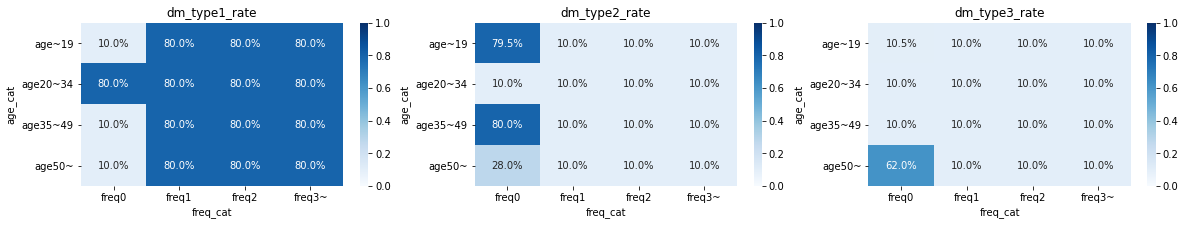

In [91]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3,figsize=(20,3))
for i in range(3):
    ptn = i+1
    df_pivot_tmp = pd.pivot_table(data=df_val[df_val.dm_type==ptn], values='result', columns='freq_cat', index='age_cat', aggfunc='mean')
    df_pivot_tmp = df_pivot_tmp.reindex([f'age{x}' for x in ['~19', '20~34', '35~49', '50~']])
    sns.heatmap(df_pivot_tmp, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'dm_type{ptn}_rate')
plt.show()

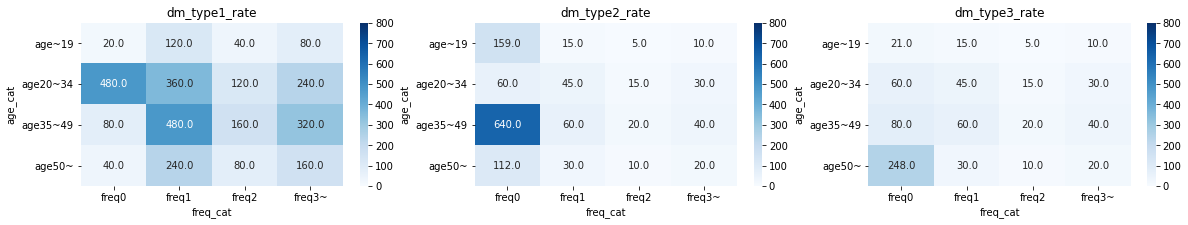

In [92]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3,figsize=(20,3))
for i in range(3):
    ptn = i+1
    df_pivot_tmp = pd.pivot_table(data=df_val[df_val.dm_type==ptn], values='result', columns='freq_cat', index='age_cat', aggfunc='sum')
    df_pivot_tmp = df_pivot_tmp.reindex([f'age{x}' for x in ['~19', '20~34', '35~49', '50~']])
    sns.heatmap(df_pivot_tmp, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'dm_type{ptn}_num')
plt.show()

# 2nd model

In [152]:
df_customers = pd.read_csv('customers.csv')
df_customers

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [153]:
df_visit = pd.read_csv('visit_probability.csv')
df_visit

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [154]:
dict_seg_num = pd.merge(df_customers, df_visit).groupby('segment_id')['customer_id'].count().to_dict()
df_val = df_visit.copy()
df_val['seg_customer_num'] = df_val.segment_id.map(dict_seg_num)

In [155]:
for i in range(3):
    ptn = i + 1
    df_val[f'diff_dm{ptn}'] = df_val[f'prob_dm{ptn}'] - df_val.prob_dm1
    df_val[f'val_dm{ptn}'] = [pulp.LpVariable(f'x_{i}_{ptn}',lowBound=0, upBound=1, cat='Continuous') for i in df_val.segment_id]
    #df_val[f'val_dm{ptn}'] = pulp.LpVariable.dict('x', f'{ptn}_' + df_visit.segment_id.astype('str'),
    #                                                 lowBound=0, upBound=1, cat='Continuous')
dict_cost = {1:0, 2:1000, 3:2000}

In [156]:
df_val

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,seg_customer_num,diff_dm1,val_dm1,diff_dm2,val_dm2,diff_dm3,val_dm3
0,age~19,freq0,1,0.07,0.12,0.29,200,0.0,x_1_1,0.05,x_1_2,0.22,x_1_3
1,age~19,freq1,2,0.21,0.30,0.58,150,0.0,x_2_1,0.09,x_2_2,0.37,x_2_3
2,age~19,freq2,3,0.28,0.39,0.74,50,0.0,x_3_1,0.11,x_3_2,0.46,x_3_3
3,age~19,freq3~,4,0.35,0.45,0.77,100,0.0,x_4_1,0.10,x_4_2,0.42,x_4_3
4,age20~34,freq0,5,0.11,0.17,0.37,600,0.0,x_5_1,0.06,x_5_2,0.26,x_5_3
5,age20~34,freq1,6,0.32,0.43,0.72,450,0.0,x_6_1,0.11,x_6_2,0.40,x_6_3
6,age20~34,freq2,7,0.42,0.55,0.93,150,0.0,x_7_1,0.13,x_7_2,0.51,x_7_3
7,age20~34,freq3~,8,0.52,0.63,0.94,300,0.0,x_8_1,0.11,x_8_2,0.42,x_8_3
8,age35~49,freq0,9,0.08,0.14,0.33,800,0.0,x_9_1,0.06,x_9_2,0.25,x_9_3
9,age35~49,freq1,10,0.25,0.35,0.67,600,0.0,x_10_1,0.10,x_10_2,0.42,x_10_3


In [157]:
problem = pulp.LpProblem('coupon2', pulp.LpMaximize)

problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'diff_dm{m}'] * r.seg_customer_num 
                       for m in [2,3] for _,r in df_val.iterrows()])

for _, r in df_val.iterrows():
    problem += pulp.lpSum([r[f'val_dm{m}'] for m in [1,2,3]]) == 1
    for m in [1,2,3]:
        problem += r[f'val_dm{m}'] >= 0.1

problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'prob_dm{m}'] * r.seg_customer_num * dict_cost[m] 
                       for m in [2,3] for _,r in df_val.iterrows()]) <= 10**6




In [158]:
import time
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'status:{pulp.LpStatus[status]}')
print(f'goal function value:{pulp.value(problem.objective):.4}')
print(f'calc time:{(time_stop - time_start)} second')

status:Optimal
goal function value:326.1
calc time:0.07221150398254395 second


In [144]:
for m in [1,2,3]:
    df_val[f'result_dm{m}'] = df_val[f'val_dm{m}'].apply(lambda x: x.value())
    df_val[f'result_num_dm{m}'] = df_val[f'result_dm{m}'] * df_val.seg_customer_num

In [147]:
df_val[[f'result_num_dm{i+1}' for i in range(3)]].sum()

result_num_dm1     500.000000
result_num_dm2    3690.476192
result_num_dm3     809.523808
dtype: float64

In [148]:
3690 * 1000 + 809 * 2000 < 10**6

False